# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» поставил перед нами задачу внедрить систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Цель иссдедования** - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Задачи исследования:**

- провести исследовательский анализ данных;
- обучить модели;
- провести анализ обученной модели.

# Содержание
* [Исследовательский анализ данных](#Исследовательский-анализ-данных)
* [Обучение модели](#Обучение-модели)
* [Анализ обученной модели](#Анализ-обученной-модели)

## Исследовательский анализ данных

In [7]:
# Загрузим необходимые библиотеки
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow import keras
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Загрузим данные 
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
# Посмотрим на размер выборки
labels.shape

(7591, 2)

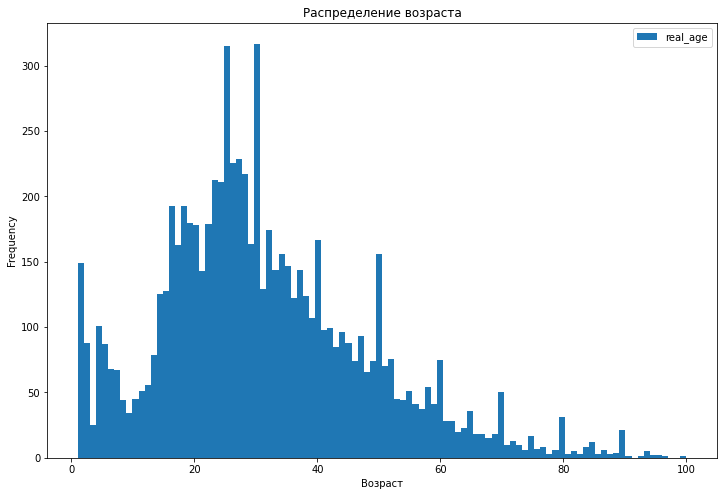

In [5]:
# Построим график распределения возраста в выборке
labels.plot(kind='hist', bins=100, figsize=(12, 8), title='Распределение возраста')
plt.xlabel('Возраст')
plt.show()

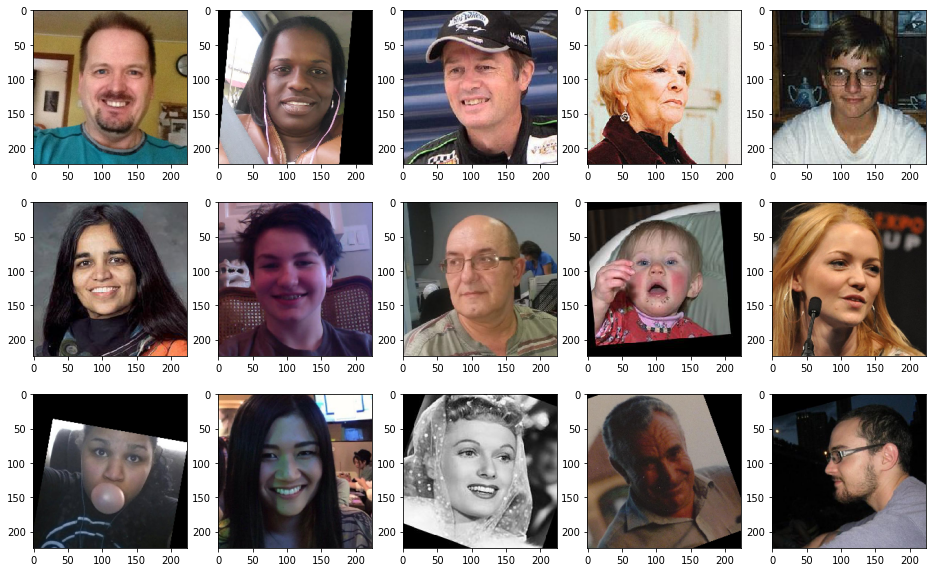

In [6]:
features, target = next(train_gen_flow)
pic_box = plt.figure(figsize=(16, 10))
for i in range(15):
    pic_box.add_subplot(3, 5, i+1)
    plt.imshow(features[i])

**Вывод**

Выборка состоит из 7591 фотографии, что сложно назвать достаточным количеством для обучения модели. Большая часть фотографий из датасета принадлежит людям от 20 до 40 лет. Обучение модели будет затруднено из-за присутствия на фотографиях различных предметов, которые могут портить качество обучения модели: микрофон, головные уборы и т.д.

## Обучение модели

Обучим нашу модель для определения возраста покупателя. Метрикой качества будет выступать MAE (средняя абсолютная ошибка).

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

2022-05-22 18:09:14.780065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-22 18:09:14.781912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-05-22 18:09:15.620027: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-22 18:09:16.294636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-22 18:09:16.294721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-22 18:09:16.294753: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-22 18:09:16.296566: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-22 18:09:16.296975: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-22 18:09:16.299305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-22 18:09:16.300514: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-22 18:09:16.300583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-22 18:09:16.304939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-22 18:09:16.305326: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-22 18:09:16.312239: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-05-22 18:09:16.312803: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x428c420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-22 18:09:16.312834: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-22 18:09:16.475072: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4312440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-22 18:09:16.475121: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-22 18:09:16.477575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-22 18:09:16.477635: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-22 18:09:16.477645: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-22 18:09:16.477676: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-22 18:09:16.477685: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-22 18:09:16.477695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-22 18:09:16.477705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-22 18:09:16.477712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-22 18:09:16.482158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-22 18:09:16.482222: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-22 18:09:16.805749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-22 18:09:16.805809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-22 18:09:16.805819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-22 18:09:16.810550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-05-22 18:09:27.626482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-22 18:09:27.935206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 206.5410 - mae: 10.4534 - val_loss: 720.0543 - val_mae: 21.8159
Epoch 2/10
356/356 - 38s - loss: 83.1735 - mae: 6.9608 - val_loss: 129.3009 - val_mae: 8.4319
Epoch 3/10
356/356 - 39s - loss: 57.0501 - mae: 5.7926 - val_loss: 78.0740 - val_mae: 6.6358
Epoch 4/10
356/356 - 39s - loss: 39.2257 - mae: 4.8174 - val_loss: 77.7653 - val_mae: 6.5571
Epoch 5/10
356/356 - 39s - loss: 31.9253 - mae: 4.3287 - val_loss: 88.8466 - val_mae: 7.3779
Epoch 6/10
356/356 - 38s - loss: 24.5340 - mae: 3.7929 - val_loss: 66.3571 - val_mae: 6.1413
Epoch 7/10
356/356 - 38s - loss: 21.0238 - mae: 3.4840 - val_loss: 71.4778 - val_mae: 6.4646
Epoch 8/10
356/356 - 38s - loss: 16.4352 - mae: 3.1121 - val_loss: 73.3814 - val_mae: 6.5373
Epoch 9/10
356/356 - 39s - loss: 14.5289 - mae: 2.8961 - val_loss: 73.0584 - val_mae: 6.3126
Epoch 10/10
356/356 - 39s - loss: 14.2322 - mae: 2.8388 - val_loss: 63.9713 - val_mae: 5.9644
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 63.9713 - mae: 5.9644
Test MAE: 5.9644



```

## Анализ обученной модели

В результате обучения модели удалось достигнуть показателя MAE (средней абсолютной ошибки) в размере 5.96, что говорит о том, что в среднем модель занижает или завышает возраст покупателя на 5.96 лет. 

Данный показатель позволит супермаркету "Хлеб-Соль" применять систему компьютерного зрения с хорошей эффективностью, предсказывая возраст покупателя. В конечном итоге это позволит с хорошей точностью предлагать покупателям подходящий товар, а также избегать недобросовестных сделок со стороны кассиров при продаже алкоголя.